# House Test 데이터 분석 (Analyst Phase)

## 0. 분석 개요
- **목적**: 주택 가격 데이터셋(`house_test.csv`)의 구조를 파악하고, 주요 변수의 분포 및 결측치 현황을 진단합니다.
- **방법론**: OSEMN (Obtain, Scrub, Explore, Model, Interpret) 프로세스를 따릅니다.
- **작성자**: Antigravity AI Agent

In [1]:
# 1. 라이브러리 임포트 (Imports)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 상수 정의 (Constants)
TOP_N_MISSING = 20  # 결측치 시각화 시 상위 N개 표시

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'AppleGothic'  # Mac 환경 한글 폰트
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

print("라이브러리 로드 완료")

라이브러리 로드 완료


## 1. Obtain (데이터 확보)
데이터를 로드하고 데이터프레임의 기본적인 형태(Shape)와 컬럼 정보를 확인합니다.

In [2]:
# 데이터 로드 relative path 사용
file_path = '../../data/house_test.csv'
df_house = pd.read_csv(file_path)

# 데이터 형태 확인
print(f"Data Shape: {df_house.shape}")
df_house.head()

Data Shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 해석 (Interpret)
- 데이터는 총 1459개의 행(관측치)과 80개의 열(특성)로 구성되어 있습니다.
- `Id` 컬럼은 식별자로 보이며, `MSSubClass`, `MSZoning` 등의 다양한 범주형 및 수치형 변수가 혼재되어 있습니다.

## 2. Scrub (데이터 전처리 및 정제)
결측치(Missing Values)와 데이터 타입(Data Types)을 확인하여 정제 방향을 설정합니다.

In [3]:
# 데이터 기본 정보 확인
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

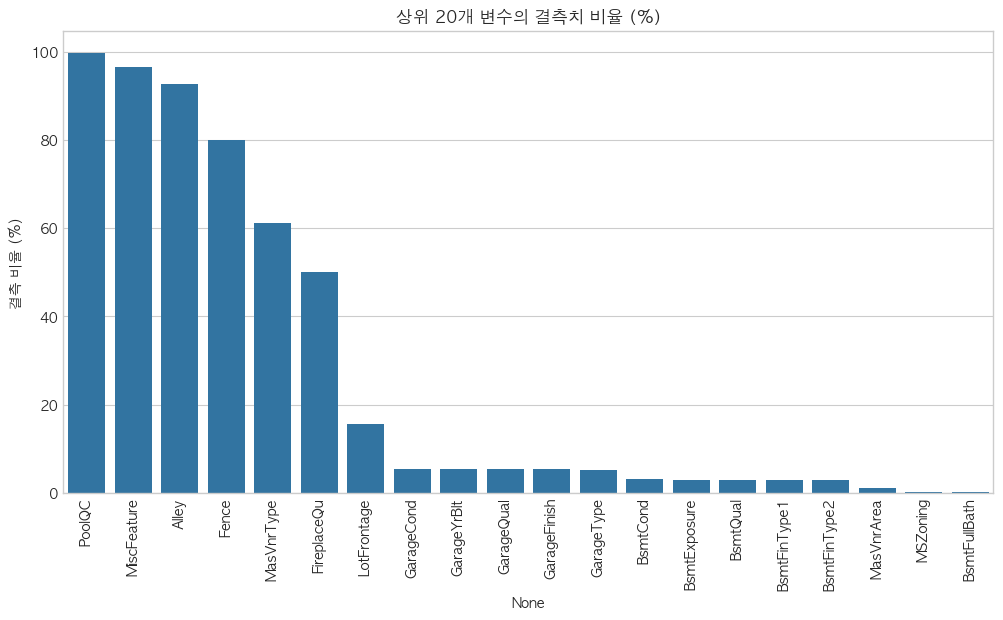

결측치가 존재하는 컬럼 수: 33


In [4]:
# 결측치 비율 확인 (상수 활용)
missing_ratio = df_house.isnull().mean() * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_ratio.index[:TOP_N_MISSING], y=missing_ratio.values[:TOP_N_MISSING])
plt.xticks(rotation=90)
plt.title(f'상위 {TOP_N_MISSING}개 변수의 결측치 비율 (%)')
plt.ylabel('결측 비율 (%)')
plt.show()

# 결측치가 있는 컬럼 수
print(f"결측치가 존재하는 컬럼 수: {len(missing_ratio)}")

### 해석 (Interpret)
- `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu` 등의 변수에서 매우 높은 결측 비율이 확인됩니다.
- 이는 해당 시설(수영장, 울타리 등)이 **존재하지 않음**을 의미할 가능성이 높으므로, 단순 제거보다는 'None' 등의 범주로 대체하는 것이 적절해 보입니다.
- `LotFrontage`는 약 15~20% 정도의 결측이 있어 중앙값 대체 등의 전략이 필요할 수 있습니다.

## 3. Explore (탐색적 데이터 분석)
주요 수치형 변수의 분포를 살펴봅니다.

In [5]:
# 수치형 변수 기술 통계량
df_house.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1459.0,2190.000000,421.321334,1461.0,1825.50,2190.0,2554.50,2919.0
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0


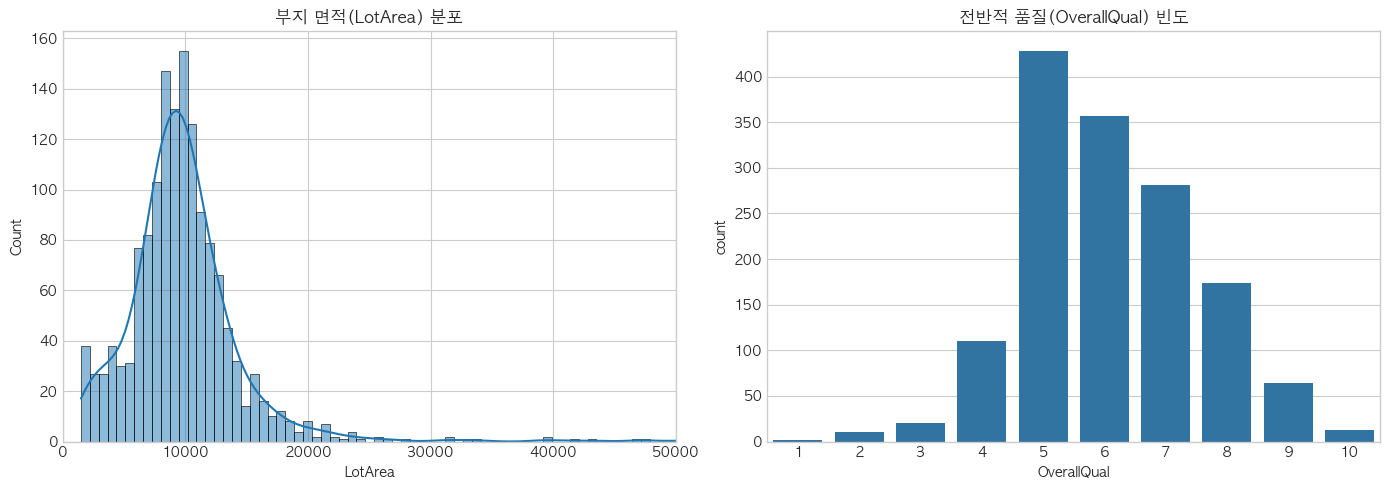

In [6]:
# 주요 변수(LotArea, OverallQual) 분포 시각화
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_house['LotArea'], kde=True, ax=ax[0])
ax[0].set_title('부지 면적(LotArea) 분포')
ax[0].set_xlim(0, 50000) # 이상치로 인한 왜곡 방지를 위해 x축 제한

sns.countplot(data=df_house, x='OverallQual', ax=ax[1])
ax[1].set_title('전반적 품질(OverallQual) 빈도')

plt.tight_layout()
plt.show()

### 해석 (Interpret)
- `LotArea`는 오른쪽으로 긴 꼬리를 가진(Right-skewed) 분포를 보입니다. 분석 시 로그 변환 등을 고려해볼 수 있습니다.
- `OverallQual`은 5~7 사이에 데이터가 집중되어 있으며, 정규분포와 유사한 형태를 보입니다.